In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from parameters import *
from dataloader_wikiart import *
from model_style import * 

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Create the dataloader
#dataset = StyleDataset()
#dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=workers, pin_memory=True)
dataloader = get_dataset()

# Dataloader usage in training loop: 
# for i, (data, target, label) in enumerate(dataloader): data=image, target=onehot encoded style, label=style

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


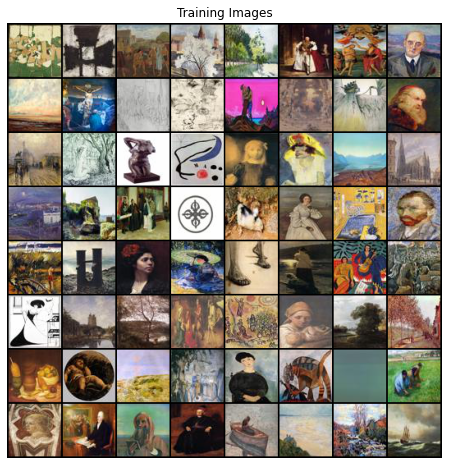

In [3]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# Create the generator
netG = Generator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(150, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [5]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (discriminate): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (

In [6]:
# Initialize BCELoss function
criterion = nn.BCELoss()
criterion_style = nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [7]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
entropies = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, style_label) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        #target = target.to(device)
        style_label = style_label.to(device)
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output, output_style = netD(real_cpu)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real = errD_real + criterion_style(output_style.squeeze(), style_label.squeeze())
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output, output_style = netD(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output, output_style = netD(fake)
        # Uniform cross entropy
        logsoftmax = nn.LogSoftmax(dim=1)
        unif = torch.full((data.shape[0], n_class), 1/n_class)
        unif = unif.to(device)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
         
        style_entropy = -1 * (nn.functional.softmax(output_style, dim=1) * nn.functional.log_softmax(output_style, dim=1))
        style_entropy = style_entropy.sum(dim=1).mean() / torch.log(torch.tensor(n_class).float())
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Entropy: %.4f' 
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, style_entropy))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        entropies.append(style_entropy)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/home/otepence/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/150][0/1273]	Loss_D: 5.2497	Loss_G: 5.1355	D(x): 0.4108	D(G(z)): 0.3470 / 0.2822	 Entropy: 0.8691
[0/150][50/1273]	Loss_D: 3.5613	Loss_G: 7.0209	D(x): 0.6944	D(G(z)): 0.3434 / 0.0454	 Entropy: 0.8740
[0/150][100/1273]	Loss_D: 3.2641	Loss_G: 7.9280	D(x): 0.8401	D(G(z)): 0.1792 / 0.0187	 Entropy: 0.8706
[0/150][150/1273]	Loss_D: 3.0913	Loss_G: 7.6106	D(x): 0.7972	D(G(z)): 0.1309 / 0.0244	 Entropy: 0.8771
[0/150][200/1273]	Loss_D: 3.0101	Loss_G: 7.9087	D(x): 0.8596	D(G(z)): 0.0946 / 0.0184	 Entropy: 0.8768
[0/150][250/1273]	Loss_D: 2.7821	Loss_G: 8.0439	D(x): 0.9045	D(G(z)): 0.0811 / 0.0144	 Entropy: 0.8951
[0/150][300/1273]	Loss_D: 3.1589	Loss_G: 8.1602	D(x): 0.8560	D(G(z)): 0.0732 / 0.0165	 Entropy: 0.8504
[0/150][350/1273]	Loss_D: 2.8953	Loss_G: 7.6290	D(x): 0.6607	D(G(z)): 0.0189 / 0.0346	 Entropy: 0.8162
[0/150][400/1273]	Loss_D: 3.2485	Loss_G: 6.3075	D(x): 0.7569	D(G(z)): 0.1714 / 0.1083	 Entropy: 0.8307
[0/150][450/1273]	Loss_D: 2.7442	Loss_G: 7.3829	D(x): 0.8696	D(G(z)): 0.1230

/home/otepence/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/150][0/1273]	Loss_D: 2.7974	Loss_G: 7.3068	D(x): 0.7885	D(G(z)): 0.1071 / 0.0685	 Entropy: 0.7724
[1/150][50/1273]	Loss_D: 2.9643	Loss_G: 6.5200	D(x): 0.7019	D(G(z)): 0.1679 / 0.1625	 Entropy: 0.7654
[1/150][100/1273]	Loss_D: 2.5655	Loss_G: 7.6475	D(x): 0.8692	D(G(z)): 0.1053 / 0.0437	 Entropy: 0.7792
[1/150][150/1273]	Loss_D: 2.7928	Loss_G: 6.7844	D(x): 0.8210	D(G(z)): 0.2810 / 0.1037	 Entropy: 0.7754
[1/150][200/1273]	Loss_D: 3.4058	Loss_G: 6.4651	D(x): 0.6561	D(G(z)): 0.1843 / 0.1925	 Entropy: 0.7123
[1/150][250/1273]	Loss_D: 2.9950	Loss_G: 7.2860	D(x): 0.8200	D(G(z)): 0.3122 / 0.0817	 Entropy: 0.7287
[1/150][300/1273]	Loss_D: 2.7360	Loss_G: 8.4878	D(x): 0.9335	D(G(z)): 0.4183 / 0.0295	 Entropy: 0.7030
[1/150][350/1273]	Loss_D: 2.8848	Loss_G: 6.8009	D(x): 0.7686	D(G(z)): 0.1698 / 0.1222	 Entropy: 0.7641
[1/150][400/1273]	Loss_D: 3.2923	Loss_G: 6.9230	D(x): 0.4389	D(G(z)): 0.0600 / 0.1172	 Entropy: 0.7294
[1/150][450/1273]	Loss_D: 2.6997	Loss_G: 7.1079	D(x): 0.8588	D(G(z)): 0.1447

[4/150][100/1273]	Loss_D: 2.5128	Loss_G: 8.3494	D(x): 0.9229	D(G(z)): 0.2561 / 0.0424	 Entropy: 0.6975
[4/150][150/1273]	Loss_D: 2.5645	Loss_G: 9.1008	D(x): 0.8911	D(G(z)): 0.2544 / 0.0230	 Entropy: 0.7147
[4/150][200/1273]	Loss_D: 2.3773	Loss_G: 8.3689	D(x): 0.8889	D(G(z)): 0.1373 / 0.0473	 Entropy: 0.6820
[4/150][250/1273]	Loss_D: 2.7034	Loss_G: 7.6801	D(x): 0.7239	D(G(z)): 0.2548 / 0.0886	 Entropy: 0.6732
[4/150][300/1273]	Loss_D: 3.1268	Loss_G: 6.5210	D(x): 0.7038	D(G(z)): 0.2670 / 0.2397	 Entropy: 0.6981
[4/150][350/1273]	Loss_D: 2.7387	Loss_G: 7.7721	D(x): 0.7556	D(G(z)): 0.0961 / 0.0712	 Entropy: 0.7122
[4/150][400/1273]	Loss_D: 2.9636	Loss_G: 8.7522	D(x): 0.9543	D(G(z)): 0.4583 / 0.0292	 Entropy: 0.6924
[4/150][450/1273]	Loss_D: 2.4819	Loss_G: 7.0537	D(x): 0.7856	D(G(z)): 0.1235 / 0.1428	 Entropy: 0.7212
[4/150][500/1273]	Loss_D: 2.8037	Loss_G: 8.4504	D(x): 0.9352	D(G(z)): 0.4265 / 0.0454	 Entropy: 0.6856
[4/150][550/1273]	Loss_D: 2.2960	Loss_G: 7.7954	D(x): 0.7811	D(G(z)): 0.1

[9/150][250/1273]	Loss_D: 1.7424	Loss_G: 9.4263	D(x): 0.9945	D(G(z)): 0.1857 / 0.0233	 Entropy: 0.6536
[9/150][300/1273]	Loss_D: 2.0306	Loss_G: 8.0683	D(x): 0.8228	D(G(z)): 0.0306 / 0.0780	 Entropy: 0.6509
[9/150][350/1273]	Loss_D: 1.8610	Loss_G: 9.2387	D(x): 0.9547	D(G(z)): 0.0315 / 0.0260	 Entropy: 0.6760
[9/150][400/1273]	Loss_D: 2.0979	Loss_G: 9.6587	D(x): 0.8972	D(G(z)): 0.0328 / 0.0160	 Entropy: 0.6696
[9/150][450/1273]	Loss_D: 1.8266	Loss_G: 10.6303	D(x): 0.9912	D(G(z)): 0.0182 / 0.0059	 Entropy: 0.6887
[9/150][500/1273]	Loss_D: 1.8180	Loss_G: 11.7228	D(x): 0.9819	D(G(z)): 0.0037 / 0.0021	 Entropy: 0.6521
[9/150][550/1273]	Loss_D: 2.0000	Loss_G: 11.5571	D(x): 0.9910	D(G(z)): 0.0172 / 0.0055	 Entropy: 0.6387
[9/150][600/1273]	Loss_D: 2.0269	Loss_G: 10.9394	D(x): 0.8722	D(G(z)): 0.0061 / 0.0061	 Entropy: 0.6450
[9/150][650/1273]	Loss_D: 2.0933	Loss_G: 12.0623	D(x): 0.9943	D(G(z)): 0.0104 / 0.0025	 Entropy: 0.6228
[9/150][700/1273]	Loss_D: 2.2332	Loss_G: 10.2495	D(x): 0.8618	D(G(z)

[12/150][300/1273]	Loss_D: 1.6757	Loss_G: 9.9428	D(x): 0.9665	D(G(z)): 0.0607 / 0.0163	 Entropy: 0.6460
[12/150][350/1273]	Loss_D: 1.9380	Loss_G: 9.1840	D(x): 0.9960	D(G(z)): 0.1119 / 0.0377	 Entropy: 0.6561
[12/150][400/1273]	Loss_D: 1.6186	Loss_G: 9.9462	D(x): 0.9807	D(G(z)): 0.0881 / 0.0185	 Entropy: 0.6296
[12/150][450/1273]	Loss_D: 1.7780	Loss_G: 9.5818	D(x): 0.8127	D(G(z)): 0.0119 / 0.0232	 Entropy: 0.6509
[12/150][500/1273]	Loss_D: 1.6784	Loss_G: 10.4087	D(x): 0.9588	D(G(z)): 0.0091 / 0.0095	 Entropy: 0.6803
[12/150][550/1273]	Loss_D: 1.7126	Loss_G: 11.1839	D(x): 0.9701	D(G(z)): 0.0148 / 0.0048	 Entropy: 0.6432
[12/150][600/1273]	Loss_D: 1.6181	Loss_G: 8.6177	D(x): 0.8612	D(G(z)): 0.0387 / 0.0618	 Entropy: 0.6404
[12/150][650/1273]	Loss_D: 1.5936	Loss_G: 9.9070	D(x): 0.9932	D(G(z)): 0.0364 / 0.0134	 Entropy: 0.6622
[12/150][700/1273]	Loss_D: 2.1637	Loss_G: 9.8675	D(x): 0.9496	D(G(z)): 0.2129 / 0.0185	 Entropy: 0.6392
[12/150][750/1273]	Loss_D: 1.7305	Loss_G: 8.5543	D(x): 0.9229	

[15/150][350/1273]	Loss_D: 1.6192	Loss_G: 9.9336	D(x): 0.8605	D(G(z)): 0.0156 / 0.0170	 Entropy: 0.6451
[15/150][400/1273]	Loss_D: 1.5930	Loss_G: 8.1119	D(x): 0.9415	D(G(z)): 0.0829 / 0.1245	 Entropy: 0.6514
[15/150][450/1273]	Loss_D: 1.6725	Loss_G: 8.7565	D(x): 0.8918	D(G(z)): 0.0538 / 0.0543	 Entropy: 0.6466
[15/150][500/1273]	Loss_D: 1.4922	Loss_G: 8.5889	D(x): 0.9862	D(G(z)): 0.0782 / 0.0708	 Entropy: 0.6093
[15/150][550/1273]	Loss_D: 1.6098	Loss_G: 8.1628	D(x): 0.8411	D(G(z)): 0.0523 / 0.1139	 Entropy: 0.6069
[15/150][600/1273]	Loss_D: 1.5875	Loss_G: 9.2577	D(x): 0.9904	D(G(z)): 0.0833 / 0.0353	 Entropy: 0.6473
[15/150][650/1273]	Loss_D: 1.9321	Loss_G: 8.9378	D(x): 0.9623	D(G(z)): 0.1757 / 0.0403	 Entropy: 0.6579
[15/150][700/1273]	Loss_D: 1.7583	Loss_G: 11.4841	D(x): 0.9995	D(G(z)): 0.1989 / 0.0036	 Entropy: 0.6495
[15/150][750/1273]	Loss_D: 2.1103	Loss_G: 12.3209	D(x): 0.9798	D(G(z)): 0.2140 / 0.0013	 Entropy: 0.6462
[15/150][800/1273]	Loss_D: 1.6338	Loss_G: 9.6124	D(x): 0.9705	

[18/150][400/1273]	Loss_D: 1.4354	Loss_G: 9.9212	D(x): 0.9725	D(G(z)): 0.0241 / 0.0208	 Entropy: 0.6227
[18/150][450/1273]	Loss_D: 2.6073	Loss_G: 13.9896	D(x): 0.9967	D(G(z)): 0.5820 / 0.0004	 Entropy: 0.6112
[18/150][500/1273]	Loss_D: 1.3394	Loss_G: 9.8272	D(x): 0.9855	D(G(z)): 0.0507 / 0.0227	 Entropy: 0.6265
[18/150][550/1273]	Loss_D: 1.5081	Loss_G: 9.2778	D(x): 0.9090	D(G(z)): 0.0384 / 0.0396	 Entropy: 0.6342
[18/150][600/1273]	Loss_D: 1.5813	Loss_G: 8.4481	D(x): 0.9245	D(G(z)): 0.0923 / 0.0930	 Entropy: 0.6240
[18/150][650/1273]	Loss_D: 1.6195	Loss_G: 10.8443	D(x): 0.9934	D(G(z)): 0.2031 / 0.0076	 Entropy: 0.6308
[18/150][700/1273]	Loss_D: 1.6320	Loss_G: 8.8406	D(x): 0.9467	D(G(z)): 0.0756 / 0.0555	 Entropy: 0.6328
[18/150][750/1273]	Loss_D: 2.6779	Loss_G: 7.6702	D(x): 0.5208	D(G(z)): 0.1709 / 0.1458	 Entropy: 0.6376
[18/150][800/1273]	Loss_D: 1.8552	Loss_G: 8.8723	D(x): 0.7553	D(G(z)): 0.0390 / 0.0560	 Entropy: 0.6488
[18/150][850/1273]	Loss_D: 1.6901	Loss_G: 8.3447	D(x): 0.8247	

[21/150][450/1273]	Loss_D: 1.2386	Loss_G: 10.5943	D(x): 0.9805	D(G(z)): 0.0309 / 0.0201	 Entropy: 0.5831
[21/150][500/1273]	Loss_D: 1.7378	Loss_G: 9.2272	D(x): 0.9527	D(G(z)): 0.0528 / 0.0578	 Entropy: 0.5859
[21/150][550/1273]	Loss_D: 1.4310	Loss_G: 8.6369	D(x): 0.9967	D(G(z)): 0.1032 / 0.0849	 Entropy: 0.5834
[21/150][600/1273]	Loss_D: 1.1190	Loss_G: 9.8311	D(x): 0.9817	D(G(z)): 0.0545 / 0.0304	 Entropy: 0.5861
[21/150][650/1273]	Loss_D: 1.6736	Loss_G: 9.8373	D(x): 0.9291	D(G(z)): 0.0442 / 0.0274	 Entropy: 0.6228
[21/150][700/1273]	Loss_D: 1.5623	Loss_G: 10.6750	D(x): 0.9494	D(G(z)): 0.0367 / 0.0152	 Entropy: 0.5862
[21/150][750/1273]	Loss_D: 1.2813	Loss_G: 9.1807	D(x): 0.9394	D(G(z)): 0.0510 / 0.0420	 Entropy: 0.6520
[21/150][800/1273]	Loss_D: 1.6680	Loss_G: 10.3748	D(x): 0.9559	D(G(z)): 0.0203 / 0.0182	 Entropy: 0.5963
[21/150][850/1273]	Loss_D: 1.7429	Loss_G: 9.3203	D(x): 0.9936	D(G(z)): 0.1546 / 0.0351	 Entropy: 0.6208
[21/150][900/1273]	Loss_D: 1.2148	Loss_G: 10.7461	D(x): 0.991

[24/150][500/1273]	Loss_D: 1.8084	Loss_G: 9.4917	D(x): 0.9697	D(G(z)): 0.0815 / 0.0475	 Entropy: 0.5907
[24/150][550/1273]	Loss_D: 1.4735	Loss_G: 9.6968	D(x): 0.9728	D(G(z)): 0.0993 / 0.0339	 Entropy: 0.6050
[24/150][600/1273]	Loss_D: 1.6363	Loss_G: 7.8245	D(x): 0.8391	D(G(z)): 0.1129 / 0.2385	 Entropy: 0.5764
[24/150][650/1273]	Loss_D: 1.6746	Loss_G: 10.0094	D(x): 0.8904	D(G(z)): 0.1419 / 0.0266	 Entropy: 0.6021
[24/150][700/1273]	Loss_D: 1.5671	Loss_G: 9.0029	D(x): 0.8563	D(G(z)): 0.0298 / 0.0735	 Entropy: 0.5860
[24/150][750/1273]	Loss_D: 1.4317	Loss_G: 9.8264	D(x): 0.9832	D(G(z)): 0.0952 / 0.0283	 Entropy: 0.6012
[24/150][800/1273]	Loss_D: 1.5590	Loss_G: 9.5207	D(x): 0.9296	D(G(z)): 0.0413 / 0.0425	 Entropy: 0.6104
[24/150][850/1273]	Loss_D: 1.3179	Loss_G: 9.3773	D(x): 0.9463	D(G(z)): 0.0344 / 0.0548	 Entropy: 0.5982
[24/150][900/1273]	Loss_D: 1.0377	Loss_G: 10.8827	D(x): 0.9855	D(G(z)): 0.0376 / 0.0123	 Entropy: 0.5997
[24/150][950/1273]	Loss_D: 1.3306	Loss_G: 8.5539	D(x): 0.8180	

[27/150][550/1273]	Loss_D: 1.9808	Loss_G: 6.7114	D(x): 0.4661	D(G(z)): 0.0516 / 0.6702	 Entropy: 0.5692
[27/150][600/1273]	Loss_D: 1.4696	Loss_G: 10.7646	D(x): 0.9813	D(G(z)): 0.2242 / 0.0156	 Entropy: 0.5812
[27/150][650/1273]	Loss_D: 1.2917	Loss_G: 10.0273	D(x): 0.8867	D(G(z)): 0.0295 / 0.0449	 Entropy: 0.5218
[27/150][700/1273]	Loss_D: 1.2419	Loss_G: 11.8699	D(x): 0.9789	D(G(z)): 0.0245 / 0.0074	 Entropy: 0.5432
[27/150][750/1273]	Loss_D: 1.5372	Loss_G: 9.7798	D(x): 0.9875	D(G(z)): 0.1435 / 0.0486	 Entropy: 0.5512
[27/150][800/1273]	Loss_D: 1.1514	Loss_G: 12.4215	D(x): 0.9137	D(G(z)): 0.0022 / 0.0035	 Entropy: 0.5548
[27/150][850/1273]	Loss_D: 1.3754	Loss_G: 10.3877	D(x): 0.9873	D(G(z)): 0.0694 / 0.0366	 Entropy: 0.5389
[27/150][900/1273]	Loss_D: 1.3651	Loss_G: 10.0221	D(x): 0.9827	D(G(z)): 0.0812 / 0.0336	 Entropy: 0.6020
[27/150][950/1273]	Loss_D: 1.1889	Loss_G: 9.3901	D(x): 0.9310	D(G(z)): 0.0956 / 0.0741	 Entropy: 0.5460
[27/150][1000/1273]	Loss_D: 1.2703	Loss_G: 9.2921	D(x): 0.

[30/150][600/1273]	Loss_D: 3.1692	Loss_G: 12.6852	D(x): 0.9985	D(G(z)): 0.7676 / 0.0024	 Entropy: 0.5914
[30/150][650/1273]	Loss_D: 1.1989	Loss_G: 10.0438	D(x): 0.8930	D(G(z)): 0.0387 / 0.0377	 Entropy: 0.5572
[30/150][700/1273]	Loss_D: 1.2519	Loss_G: 9.6872	D(x): 0.9353	D(G(z)): 0.0647 / 0.0569	 Entropy: 0.5455
[30/150][750/1273]	Loss_D: 1.1516	Loss_G: 9.8490	D(x): 0.8757	D(G(z)): 0.0202 / 0.0486	 Entropy: 0.5632
[30/150][800/1273]	Loss_D: 1.1987	Loss_G: 9.3471	D(x): 0.8378	D(G(z)): 0.0365 / 0.1024	 Entropy: 0.5575
[30/150][850/1273]	Loss_D: 1.5359	Loss_G: 8.0834	D(x): 0.6997	D(G(z)): 0.0241 / 0.3103	 Entropy: 0.5330
[30/150][900/1273]	Loss_D: 1.3410	Loss_G: 9.9442	D(x): 0.8687	D(G(z)): 0.0339 / 0.0581	 Entropy: 0.5558
[30/150][950/1273]	Loss_D: 1.6744	Loss_G: 12.0461	D(x): 0.9373	D(G(z)): 0.2499 / 0.0066	 Entropy: 0.5226
[30/150][1000/1273]	Loss_D: 1.1553	Loss_G: 10.3225	D(x): 0.9608	D(G(z)): 0.0427 / 0.0324	 Entropy: 0.5716
[30/150][1050/1273]	Loss_D: 1.4068	Loss_G: 9.7651	D(x): 0.9

[33/150][650/1273]	Loss_D: 1.0673	Loss_G: 10.8794	D(x): 0.9864	D(G(z)): 0.2147 / 0.0181	 Entropy: 0.5427
[33/150][700/1273]	Loss_D: 0.9881	Loss_G: 10.9962	D(x): 0.9632	D(G(z)): 0.0513 / 0.0235	 Entropy: 0.5266
[33/150][750/1273]	Loss_D: 3.2395	Loss_G: 10.6317	D(x): 0.7765	D(G(z)): 0.5793 / 0.0354	 Entropy: 0.5605
[33/150][800/1273]	Loss_D: 1.4221	Loss_G: 8.2582	D(x): 0.7296	D(G(z)): 0.0521 / 0.2546	 Entropy: 0.5554
[33/150][850/1273]	Loss_D: 1.2912	Loss_G: 10.1676	D(x): 0.9397	D(G(z)): 0.0420 / 0.0418	 Entropy: 0.5350
[33/150][900/1273]	Loss_D: 1.2893	Loss_G: 9.5763	D(x): 0.9333	D(G(z)): 0.0626 / 0.0736	 Entropy: 0.5431
[33/150][950/1273]	Loss_D: 1.5014	Loss_G: 8.0020	D(x): 0.7187	D(G(z)): 0.0506 / 0.2906	 Entropy: 0.5447
[33/150][1000/1273]	Loss_D: 1.0746	Loss_G: 10.3813	D(x): 0.9156	D(G(z)): 0.0520 / 0.0379	 Entropy: 0.5243
[33/150][1050/1273]	Loss_D: 1.5693	Loss_G: 10.2525	D(x): 0.8996	D(G(z)): 0.0821 / 0.0439	 Entropy: 0.5488
[33/150][1100/1273]	Loss_D: 1.1392	Loss_G: 11.7026	D(x):

[36/150][700/1273]	Loss_D: 1.1437	Loss_G: 9.9316	D(x): 0.8872	D(G(z)): 0.0355 / 0.1056	 Entropy: 0.4903
[36/150][750/1273]	Loss_D: 0.9022	Loss_G: 11.5110	D(x): 0.9657	D(G(z)): 0.0222 / 0.0174	 Entropy: 0.5253
[36/150][800/1273]	Loss_D: 1.2542	Loss_G: 9.2451	D(x): 0.7510	D(G(z)): 0.0175 / 0.1459	 Entropy: 0.5011
[36/150][850/1273]	Loss_D: 1.6186	Loss_G: 9.4800	D(x): 0.6393	D(G(z)): 0.0678 / 0.1001	 Entropy: 0.5222
[36/150][900/1273]	Loss_D: 1.2866	Loss_G: 8.7621	D(x): 0.7841	D(G(z)): 0.0487 / 0.1752	 Entropy: 0.5347
[36/150][950/1273]	Loss_D: 1.0619	Loss_G: 10.4988	D(x): 0.9832	D(G(z)): 0.0758 / 0.0404	 Entropy: 0.5259
[36/150][1000/1273]	Loss_D: 0.8959	Loss_G: 10.8912	D(x): 0.9425	D(G(z)): 0.1209 / 0.0263	 Entropy: 0.5224
[36/150][1050/1273]	Loss_D: 1.1895	Loss_G: 9.1868	D(x): 0.7978	D(G(z)): 0.0632 / 0.1118	 Entropy: 0.5466
[36/150][1100/1273]	Loss_D: 1.0499	Loss_G: 9.8272	D(x): 0.9647	D(G(z)): 0.0375 / 0.0628	 Entropy: 0.5287
[36/150][1150/1273]	Loss_D: 5.9768	Loss_G: 16.1172	D(x): 0

[39/150][750/1273]	Loss_D: 1.0950	Loss_G: 11.1278	D(x): 0.9487	D(G(z)): 0.1479 / 0.0200	 Entropy: 0.5058
[39/150][800/1273]	Loss_D: 0.8276	Loss_G: 11.0152	D(x): 0.9065	D(G(z)): 0.0265 / 0.0288	 Entropy: 0.5111
[39/150][850/1273]	Loss_D: 0.9443	Loss_G: 10.5321	D(x): 0.9676	D(G(z)): 0.0799 / 0.0376	 Entropy: 0.5216
[39/150][900/1273]	Loss_D: 1.0035	Loss_G: 11.2257	D(x): 0.9479	D(G(z)): 0.1672 / 0.0291	 Entropy: 0.4956
[39/150][950/1273]	Loss_D: 1.7058	Loss_G: 11.6984	D(x): 0.9919	D(G(z)): 0.3953 / 0.0173	 Entropy: 0.4776
[39/150][1000/1273]	Loss_D: 4.3999	Loss_G: 8.2233	D(x): 0.1053	D(G(z)): 0.0021 / 0.4178	 Entropy: 0.4758
[39/150][1050/1273]	Loss_D: 1.0942	Loss_G: 11.0465	D(x): 0.9600	D(G(z)): 0.0834 / 0.0341	 Entropy: 0.4773
[39/150][1100/1273]	Loss_D: 1.0255	Loss_G: 11.6656	D(x): 0.9937	D(G(z)): 0.1627 / 0.0201	 Entropy: 0.4799
[39/150][1150/1273]	Loss_D: 1.2618	Loss_G: 10.9251	D(x): 0.9398	D(G(z)): 0.1159 / 0.0392	 Entropy: 0.4912
[39/150][1200/1273]	Loss_D: 1.1231	Loss_G: 13.0845	D

[42/150][800/1273]	Loss_D: 0.7898	Loss_G: 11.0489	D(x): 0.9330	D(G(z)): 0.0738 / 0.0301	 Entropy: 0.5013
[42/150][850/1273]	Loss_D: 1.1692	Loss_G: 11.6954	D(x): 0.8792	D(G(z)): 0.0516 / 0.0266	 Entropy: 0.4720
[42/150][900/1273]	Loss_D: 1.0707	Loss_G: 10.9631	D(x): 0.9628	D(G(z)): 0.1077 / 0.0498	 Entropy: 0.4611
[42/150][950/1273]	Loss_D: 0.8953	Loss_G: 12.4791	D(x): 0.8908	D(G(z)): 0.0158 / 0.0091	 Entropy: 0.5257
[42/150][1000/1273]	Loss_D: 0.8949	Loss_G: 9.2615	D(x): 0.8798	D(G(z)): 0.0505 / 0.1512	 Entropy: 0.4749
[42/150][1050/1273]	Loss_D: 0.8668	Loss_G: 10.0814	D(x): 0.9085	D(G(z)): 0.0696 / 0.0908	 Entropy: 0.4805
[42/150][1100/1273]	Loss_D: 1.0583	Loss_G: 11.6409	D(x): 0.9914	D(G(z)): 0.1527 / 0.0224	 Entropy: 0.4676
[42/150][1150/1273]	Loss_D: 0.9041	Loss_G: 11.6969	D(x): 0.9707	D(G(z)): 0.1587 / 0.0193	 Entropy: 0.4660
[42/150][1200/1273]	Loss_D: 1.1790	Loss_G: 12.5532	D(x): 0.9691	D(G(z)): 0.0956 / 0.0090	 Entropy: 0.4899
[42/150][1250/1273]	Loss_D: 1.0867	Loss_G: 11.5744	

[45/150][850/1273]	Loss_D: 0.9386	Loss_G: 11.1930	D(x): 0.9917	D(G(z)): 0.0843 / 0.0386	 Entropy: 0.4529
[45/150][900/1273]	Loss_D: 1.3265	Loss_G: 12.2051	D(x): 0.9412	D(G(z)): 0.2367 / 0.0126	 Entropy: 0.4643
[45/150][950/1273]	Loss_D: 0.8774	Loss_G: 12.2700	D(x): 0.9874	D(G(z)): 0.1486 / 0.0118	 Entropy: 0.4787
[45/150][1000/1273]	Loss_D: 1.0544	Loss_G: 10.2481	D(x): 0.8727	D(G(z)): 0.0999 / 0.0858	 Entropy: 0.4718
[45/150][1050/1273]	Loss_D: 0.7796	Loss_G: 11.1045	D(x): 0.9073	D(G(z)): 0.0422 / 0.0424	 Entropy: 0.4814
[45/150][1100/1273]	Loss_D: 0.9217	Loss_G: 11.5482	D(x): 0.9054	D(G(z)): 0.0282 / 0.0289	 Entropy: 0.4594
[45/150][1150/1273]	Loss_D: 0.8702	Loss_G: 12.0097	D(x): 0.9481	D(G(z)): 0.0193 / 0.0183	 Entropy: 0.4773
[45/150][1200/1273]	Loss_D: 0.7927	Loss_G: 11.2186	D(x): 0.9048	D(G(z)): 0.0941 / 0.0508	 Entropy: 0.4317
[45/150][1250/1273]	Loss_D: 1.1758	Loss_G: 11.7791	D(x): 0.9765	D(G(z)): 0.0707 / 0.0260	 Entropy: 0.4533
[46/150][0/1273]	Loss_D: 0.9514	Loss_G: 12.3719	D

[48/150][900/1273]	Loss_D: 0.7062	Loss_G: 10.8189	D(x): 0.9357	D(G(z)): 0.0694 / 0.0804	 Entropy: 0.4507
[48/150][950/1273]	Loss_D: 0.8298	Loss_G: 11.6144	D(x): 0.9715	D(G(z)): 0.0834 / 0.0264	 Entropy: 0.4706
[48/150][1000/1273]	Loss_D: 0.7479	Loss_G: 12.3603	D(x): 0.9892	D(G(z)): 0.2230 / 0.0106	 Entropy: 0.4637
[48/150][1050/1273]	Loss_D: 1.0914	Loss_G: 9.1417	D(x): 0.8155	D(G(z)): 0.1662 / 0.2735	 Entropy: 0.4657
[48/150][1100/1273]	Loss_D: 0.9720	Loss_G: 12.2580	D(x): 0.9958	D(G(z)): 0.2307 / 0.0139	 Entropy: 0.4555
[48/150][1150/1273]	Loss_D: 0.8844	Loss_G: 11.3666	D(x): 0.9999	D(G(z)): 0.1475 / 0.0279	 Entropy: 0.4840
[48/150][1200/1273]	Loss_D: 0.7758	Loss_G: 11.3496	D(x): 0.9835	D(G(z)): 0.0386 / 0.0398	 Entropy: 0.4575
[48/150][1250/1273]	Loss_D: 0.8899	Loss_G: 11.9268	D(x): 0.9497	D(G(z)): 0.0224 / 0.0147	 Entropy: 0.4991
[49/150][0/1273]	Loss_D: 1.5543	Loss_G: 8.6396	D(x): 0.5275	D(G(z)): 0.0200 / 0.5507	 Entropy: 0.4281
[49/150][50/1273]	Loss_D: 0.7670	Loss_G: 11.2685	D(x)

[51/150][950/1273]	Loss_D: 1.1684	Loss_G: 14.0253	D(x): 0.7652	D(G(z)): 0.0024 / 0.0036	 Entropy: 0.4386
[51/150][1000/1273]	Loss_D: 0.8849	Loss_G: 10.8756	D(x): 0.9574	D(G(z)): 0.1881 / 0.0711	 Entropy: 0.4509
[51/150][1050/1273]	Loss_D: 0.6858	Loss_G: 12.2040	D(x): 0.9156	D(G(z)): 0.0245 / 0.0271	 Entropy: 0.4516
[51/150][1100/1273]	Loss_D: 0.7500	Loss_G: 12.1591	D(x): 0.9390	D(G(z)): 0.0372 / 0.0185	 Entropy: 0.4390
[51/150][1150/1273]	Loss_D: 0.8398	Loss_G: 12.8158	D(x): 0.9713	D(G(z)): 0.0628 / 0.0127	 Entropy: 0.4098
[51/150][1200/1273]	Loss_D: 0.9315	Loss_G: 9.8473	D(x): 0.7904	D(G(z)): 0.0236 / 0.1660	 Entropy: 0.4557
[51/150][1250/1273]	Loss_D: 1.0020	Loss_G: 11.0113	D(x): 0.8905	D(G(z)): 0.1395 / 0.0856	 Entropy: 0.4382
[52/150][0/1273]	Loss_D: 0.6610	Loss_G: 11.5541	D(x): 0.9185	D(G(z)): 0.0205 / 0.0452	 Entropy: 0.4498
[52/150][50/1273]	Loss_D: 0.6129	Loss_G: 11.6394	D(x): 0.9623	D(G(z)): 0.1515 / 0.0282	 Entropy: 0.4527
[52/150][100/1273]	Loss_D: 0.5461	Loss_G: 14.3141	D(x

[54/150][950/1273]	Loss_D: 1.4178	Loss_G: 14.3908	D(x): 0.9884	D(G(z)): 0.4041 / 0.0021	 Entropy: 0.4509
[54/150][1000/1273]	Loss_D: 0.7553	Loss_G: 11.9122	D(x): 0.9591	D(G(z)): 0.0379 / 0.0250	 Entropy: 0.4441
[54/150][1050/1273]	Loss_D: 0.9286	Loss_G: 12.6751	D(x): 0.9760	D(G(z)): 0.1819 / 0.0231	 Entropy: 0.3994
[54/150][1100/1273]	Loss_D: 0.6165	Loss_G: 12.6407	D(x): 0.9851	D(G(z)): 0.0515 / 0.0174	 Entropy: 0.4306
[54/150][1150/1273]	Loss_D: 1.1013	Loss_G: 11.2243	D(x): 0.7670	D(G(z)): 0.0419 / 0.0584	 Entropy: 0.4685
[54/150][1200/1273]	Loss_D: 0.7221	Loss_G: 12.4072	D(x): 0.9914	D(G(z)): 0.0505 / 0.0226	 Entropy: 0.4311
[54/150][1250/1273]	Loss_D: 1.0432	Loss_G: 14.8508	D(x): 0.9947	D(G(z)): 0.2871 / 0.0012	 Entropy: 0.4556
[55/150][0/1273]	Loss_D: 1.1498	Loss_G: 14.4178	D(x): 0.9853	D(G(z)): 0.3287 / 0.0023	 Entropy: 0.4364
[55/150][50/1273]	Loss_D: 0.9019	Loss_G: 11.4893	D(x): 0.9879	D(G(z)): 0.2105 / 0.0421	 Entropy: 0.4507
[55/150][100/1273]	Loss_D: 0.9558	Loss_G: 12.1248	D(

[57/150][950/1273]	Loss_D: 0.8348	Loss_G: 10.4340	D(x): 0.7924	D(G(z)): 0.0259 / 0.1559	 Entropy: 0.4022
[57/150][1000/1273]	Loss_D: 0.9251	Loss_G: 13.6391	D(x): 0.8924	D(G(z)): 0.0071 / 0.0101	 Entropy: 0.3850
[57/150][1050/1273]	Loss_D: 0.5641	Loss_G: 12.9647	D(x): 0.9848	D(G(z)): 0.0251 / 0.0164	 Entropy: 0.3965
[57/150][1100/1273]	Loss_D: 0.6396	Loss_G: 12.3562	D(x): 0.9693	D(G(z)): 0.0589 / 0.0292	 Entropy: 0.4219
[57/150][1150/1273]	Loss_D: 1.0460	Loss_G: 12.0906	D(x): 0.7995	D(G(z)): 0.0550 / 0.0457	 Entropy: 0.3916
[57/150][1200/1273]	Loss_D: 0.8307	Loss_G: 12.4752	D(x): 0.9922	D(G(z)): 0.0614 / 0.0356	 Entropy: 0.3979
[57/150][1250/1273]	Loss_D: 0.7296	Loss_G: 12.4369	D(x): 0.9964	D(G(z)): 0.1294 / 0.0182	 Entropy: 0.4277
[58/150][0/1273]	Loss_D: 0.7462	Loss_G: 10.9156	D(x): 0.7462	D(G(z)): 0.0129 / 0.0918	 Entropy: 0.4506
[58/150][50/1273]	Loss_D: 0.4055	Loss_G: 14.4732	D(x): 0.9844	D(G(z)): 0.0135 / 0.0036	 Entropy: 0.3913
[58/150][100/1273]	Loss_D: 0.4913	Loss_G: 11.7977	D(

[60/150][950/1273]	Loss_D: 0.9646	Loss_G: 13.2329	D(x): 0.9825	D(G(z)): 0.2007 / 0.0147	 Entropy: 0.4023
[60/150][1000/1273]	Loss_D: 0.7445	Loss_G: 13.3847	D(x): 0.9661	D(G(z)): 0.0344 / 0.0111	 Entropy: 0.4125
[60/150][1050/1273]	Loss_D: 0.9281	Loss_G: 12.1948	D(x): 0.8928	D(G(z)): 0.1507 / 0.0473	 Entropy: 0.3719
[60/150][1100/1273]	Loss_D: 0.8945	Loss_G: 11.4348	D(x): 0.9811	D(G(z)): 0.1817 / 0.0936	 Entropy: 0.3729
[60/150][1150/1273]	Loss_D: 0.7000	Loss_G: 12.5479	D(x): 0.9887	D(G(z)): 0.0316 / 0.0231	 Entropy: 0.4263
[60/150][1200/1273]	Loss_D: 0.9460	Loss_G: 13.9419	D(x): 0.9907	D(G(z)): 0.2964 / 0.0076	 Entropy: 0.3692
[60/150][1250/1273]	Loss_D: 0.7284	Loss_G: 13.0579	D(x): 0.9874	D(G(z)): 0.0819 / 0.0176	 Entropy: 0.4147
[61/150][0/1273]	Loss_D: 0.6451	Loss_G: 11.2215	D(x): 0.8559	D(G(z)): 0.0136 / 0.0762	 Entropy: 0.4091
[61/150][50/1273]	Loss_D: 0.5161	Loss_G: 12.2037	D(x): 0.9815	D(G(z)): 0.0504 / 0.0382	 Entropy: 0.4247
[61/150][100/1273]	Loss_D: 0.6194	Loss_G: 11.3861	D(

[63/150][950/1273]	Loss_D: 0.5532	Loss_G: 12.4300	D(x): 0.9351	D(G(z)): 0.0369 / 0.0389	 Entropy: 0.4021
[63/150][1000/1273]	Loss_D: 0.4467	Loss_G: 12.8400	D(x): 0.9936	D(G(z)): 0.0375 / 0.0261	 Entropy: 0.3999
[63/150][1050/1273]	Loss_D: 0.5264	Loss_G: 13.4557	D(x): 0.9728	D(G(z)): 0.0341 / 0.0153	 Entropy: 0.4104
[63/150][1100/1273]	Loss_D: 0.7357	Loss_G: 13.2866	D(x): 0.9837	D(G(z)): 0.0853 / 0.0115	 Entropy: 0.4361
[63/150][1150/1273]	Loss_D: 0.7926	Loss_G: 11.8941	D(x): 0.9348	D(G(z)): 0.0569 / 0.0477	 Entropy: 0.4137
[63/150][1200/1273]	Loss_D: 0.5939	Loss_G: 12.8410	D(x): 0.8904	D(G(z)): 0.0176 / 0.0352	 Entropy: 0.3979
[63/150][1250/1273]	Loss_D: 1.2599	Loss_G: 12.5649	D(x): 0.8903	D(G(z)): 0.2253 / 0.0260	 Entropy: 0.3945
[64/150][0/1273]	Loss_D: 0.4718	Loss_G: 13.6471	D(x): 0.9416	D(G(z)): 0.1394 / 0.0074	 Entropy: 0.4095
[64/150][50/1273]	Loss_D: 1.7682	Loss_G: 17.1840	D(x): 0.9849	D(G(z)): 0.5734 / 0.0006	 Entropy: 0.3600
[64/150][100/1273]	Loss_D: 0.6683	Loss_G: 11.1959	D(

[66/150][950/1273]	Loss_D: 0.5160	Loss_G: 13.1118	D(x): 0.9829	D(G(z)): 0.0761 / 0.0174	 Entropy: 0.4296
[66/150][1000/1273]	Loss_D: 0.5915	Loss_G: 13.7762	D(x): 0.9547	D(G(z)): 0.0117 / 0.0097	 Entropy: 0.4234
[66/150][1050/1273]	Loss_D: 0.5337	Loss_G: 14.4654	D(x): 0.9955	D(G(z)): 0.0098 / 0.0059	 Entropy: 0.4086
[66/150][1100/1273]	Loss_D: 0.6009	Loss_G: 13.2854	D(x): 0.9882	D(G(z)): 0.0255 / 0.0171	 Entropy: 0.3954
[66/150][1150/1273]	Loss_D: 0.6559	Loss_G: 11.6016	D(x): 0.8516	D(G(z)): 0.0321 / 0.1003	 Entropy: 0.3718
[66/150][1200/1273]	Loss_D: 1.1149	Loss_G: 10.8199	D(x): 0.7504	D(G(z)): 0.1117 / 0.1783	 Entropy: 0.3686
[66/150][1250/1273]	Loss_D: 0.5689	Loss_G: 12.8092	D(x): 0.9472	D(G(z)): 0.1456 / 0.0267	 Entropy: 0.3839
[67/150][0/1273]	Loss_D: 0.6558	Loss_G: 13.7057	D(x): 0.9971	D(G(z)): 0.0385 / 0.0121	 Entropy: 0.3890
[67/150][50/1273]	Loss_D: 0.3131	Loss_G: 13.1601	D(x): 0.9972	D(G(z)): 0.0459 / 0.0267	 Entropy: 0.3867
[67/150][100/1273]	Loss_D: 1.5038	Loss_G: 16.0249	D(

[69/150][950/1273]	Loss_D: 0.5118	Loss_G: 12.0135	D(x): 0.8872	D(G(z)): 0.0271 / 0.0822	 Entropy: 0.3588
[69/150][1000/1273]	Loss_D: 0.4828	Loss_G: 12.2473	D(x): 0.9117	D(G(z)): 0.0518 / 0.0841	 Entropy: 0.3453
[69/150][1050/1273]	Loss_D: 0.9982	Loss_G: 11.7299	D(x): 0.8222	D(G(z)): 0.0320 / 0.0928	 Entropy: 0.3780
[69/150][1100/1273]	Loss_D: 0.5757	Loss_G: 12.6598	D(x): 0.9413	D(G(z)): 0.0302 / 0.0410	 Entropy: 0.4049
[69/150][1150/1273]	Loss_D: 0.6095	Loss_G: 13.1152	D(x): 0.9029	D(G(z)): 0.0170 / 0.0265	 Entropy: 0.3828
[69/150][1200/1273]	Loss_D: 0.7560	Loss_G: 12.2273	D(x): 0.7518	D(G(z)): 0.0057 / 0.0856	 Entropy: 0.3549
[69/150][1250/1273]	Loss_D: 0.9909	Loss_G: 13.3813	D(x): 0.9219	D(G(z)): 0.0917 / 0.0181	 Entropy: 0.3972
[70/150][0/1273]	Loss_D: 0.8775	Loss_G: 13.8269	D(x): 0.9715	D(G(z)): 0.2651 / 0.0130	 Entropy: 0.4014
[70/150][50/1273]	Loss_D: 0.5891	Loss_G: 12.3900	D(x): 0.9932	D(G(z)): 0.1268 / 0.0417	 Entropy: 0.3850
[70/150][100/1273]	Loss_D: 0.3875	Loss_G: 13.0287	D(

[72/150][950/1273]	Loss_D: 0.5625	Loss_G: 12.8218	D(x): 0.8452	D(G(z)): 0.0181 / 0.0451	 Entropy: 0.3505
[72/150][1000/1273]	Loss_D: 0.4630	Loss_G: 12.9526	D(x): 0.8940	D(G(z)): 0.0333 / 0.0485	 Entropy: 0.3690
[72/150][1050/1273]	Loss_D: 0.6485	Loss_G: 14.9881	D(x): 0.7990	D(G(z)): 0.0077 / 0.0071	 Entropy: 0.3930
[72/150][1100/1273]	Loss_D: 0.4269	Loss_G: 14.6806	D(x): 0.9836	D(G(z)): 0.0323 / 0.0095	 Entropy: 0.3440
[72/150][1150/1273]	Loss_D: 0.5331	Loss_G: 13.8340	D(x): 0.9295	D(G(z)): 0.0467 / 0.0183	 Entropy: 0.3568
[72/150][1200/1273]	Loss_D: 0.6285	Loss_G: 12.3120	D(x): 0.9433	D(G(z)): 0.1106 / 0.0911	 Entropy: 0.3308
[72/150][1250/1273]	Loss_D: 0.4866	Loss_G: 13.9842	D(x): 0.9698	D(G(z)): 0.0096 / 0.0156	 Entropy: 0.3915
[73/150][0/1273]	Loss_D: 0.4723	Loss_G: 12.8380	D(x): 0.9404	D(G(z)): 0.0979 / 0.0443	 Entropy: 0.3571
[73/150][50/1273]	Loss_D: 0.3065	Loss_G: 13.5125	D(x): 0.9888	D(G(z)): 0.0292 / 0.0152	 Entropy: 0.4001
[73/150][100/1273]	Loss_D: 0.4523	Loss_G: 13.6061	D(

[75/150][950/1273]	Loss_D: 0.5115	Loss_G: 12.6148	D(x): 0.9194	D(G(z)): 0.0175 / 0.0422	 Entropy: 0.3748
[75/150][1000/1273]	Loss_D: 0.5777	Loss_G: 14.2149	D(x): 0.9774	D(G(z)): 0.0192 / 0.0116	 Entropy: 0.3595
[75/150][1050/1273]	Loss_D: 0.7569	Loss_G: 13.1865	D(x): 0.9395	D(G(z)): 0.0802 / 0.0350	 Entropy: 0.3576
[75/150][1100/1273]	Loss_D: 0.9006	Loss_G: 13.1454	D(x): 0.9998	D(G(z)): 0.2035 / 0.0268	 Entropy: 0.3823
[75/150][1150/1273]	Loss_D: 0.4535	Loss_G: 13.2236	D(x): 0.9751	D(G(z)): 0.0669 / 0.0454	 Entropy: 0.3381
[75/150][1200/1273]	Loss_D: 0.4598	Loss_G: 13.8691	D(x): 0.9798	D(G(z)): 0.0376 / 0.0190	 Entropy: 0.3519
[75/150][1250/1273]	Loss_D: 0.4192	Loss_G: 12.8271	D(x): 0.9333	D(G(z)): 0.0422 / 0.0689	 Entropy: 0.3572
[76/150][0/1273]	Loss_D: 0.6532	Loss_G: 14.0508	D(x): 0.8151	D(G(z)): 0.0038 / 0.0307	 Entropy: 0.3161
[76/150][50/1273]	Loss_D: 0.7377	Loss_G: 12.7377	D(x): 0.8002	D(G(z)): 0.0255 / 0.0503	 Entropy: 0.3683
[76/150][100/1273]	Loss_D: 0.5490	Loss_G: 17.1612	D(

[78/150][950/1273]	Loss_D: 2.2320	Loss_G: 18.1986	D(x): 0.9976	D(G(z)): 0.7350 / 0.0002	 Entropy: 0.3584
[78/150][1000/1273]	Loss_D: 0.3812	Loss_G: 13.8192	D(x): 0.9951	D(G(z)): 0.1238 / 0.0246	 Entropy: 0.3688
[78/150][1050/1273]	Loss_D: 0.5063	Loss_G: 13.5519	D(x): 0.9694	D(G(z)): 0.0369 / 0.0352	 Entropy: 0.3608
[78/150][1100/1273]	Loss_D: 0.3268	Loss_G: 15.2042	D(x): 0.9963	D(G(z)): 0.0367 / 0.0058	 Entropy: 0.3585
[78/150][1150/1273]	Loss_D: 0.5328	Loss_G: 14.0289	D(x): 0.9387	D(G(z)): 0.1043 / 0.0168	 Entropy: 0.3295
[78/150][1200/1273]	Loss_D: 1.0338	Loss_G: 13.3871	D(x): 0.9876	D(G(z)): 0.1936 / 0.0544	 Entropy: 0.3407
[78/150][1250/1273]	Loss_D: 0.5570	Loss_G: 14.0847	D(x): 0.9960	D(G(z)): 0.1154 / 0.0174	 Entropy: 0.3739
[79/150][0/1273]	Loss_D: 0.4648	Loss_G: 12.9196	D(x): 0.9036	D(G(z)): 0.0434 / 0.0547	 Entropy: 0.3441
[79/150][50/1273]	Loss_D: 0.3255	Loss_G: 14.6217	D(x): 0.9934	D(G(z)): 0.0299 / 0.0112	 Entropy: 0.3625
[79/150][100/1273]	Loss_D: 0.3218	Loss_G: 14.2531	D(

[81/150][950/1273]	Loss_D: 0.3555	Loss_G: 14.6747	D(x): 0.9967	D(G(z)): 0.0364 / 0.0118	 Entropy: 0.3361
[81/150][1000/1273]	Loss_D: 1.8378	Loss_G: 17.2394	D(x): 0.9967	D(G(z)): 0.4591 / 0.0008	 Entropy: 0.3361
[81/150][1050/1273]	Loss_D: 0.8019	Loss_G: 12.1966	D(x): 0.7368	D(G(z)): 0.0120 / 0.1309	 Entropy: 0.3443
[81/150][1100/1273]	Loss_D: 1.3463	Loss_G: 10.0479	D(x): 0.5890	D(G(z)): 0.0261 / 0.7232	 Entropy: 0.3565
[81/150][1150/1273]	Loss_D: 1.1332	Loss_G: 14.2613	D(x): 0.9887	D(G(z)): 0.0761 / 0.0230	 Entropy: 0.3480
[81/150][1200/1273]	Loss_D: 0.5597	Loss_G: 14.4815	D(x): 0.9647	D(G(z)): 0.0542 / 0.0176	 Entropy: 0.3497
[81/150][1250/1273]	Loss_D: 0.5545	Loss_G: 14.3712	D(x): 0.9317	D(G(z)): 0.0265 / 0.0164	 Entropy: 0.3510
[82/150][0/1273]	Loss_D: 0.6030	Loss_G: 14.5692	D(x): 0.9998	D(G(z)): 0.1083 / 0.0144	 Entropy: 0.3396
[82/150][50/1273]	Loss_D: 0.5073	Loss_G: 12.5938	D(x): 0.8622	D(G(z)): 0.0820 / 0.0725	 Entropy: 0.3538
[82/150][100/1273]	Loss_D: 0.5172	Loss_G: 13.6309	D(

[84/150][950/1273]	Loss_D: 0.3147	Loss_G: 16.0722	D(x): 0.9823	D(G(z)): 0.0072 / 0.0046	 Entropy: 0.3358
[84/150][1000/1273]	Loss_D: 0.6109	Loss_G: 13.1803	D(x): 0.9469	D(G(z)): 0.0768 / 0.0579	 Entropy: 0.3337
[84/150][1050/1273]	Loss_D: 0.8990	Loss_G: 12.3202	D(x): 0.7499	D(G(z)): 0.0438 / 0.1141	 Entropy: 0.3290
[84/150][1100/1273]	Loss_D: 0.3568	Loss_G: 13.5920	D(x): 0.9607	D(G(z)): 0.0340 / 0.0263	 Entropy: 0.3401
[84/150][1150/1273]	Loss_D: 0.4092	Loss_G: 13.9919	D(x): 0.9798	D(G(z)): 0.0551 / 0.0207	 Entropy: 0.4087
[84/150][1200/1273]	Loss_D: 0.4826	Loss_G: 14.1107	D(x): 0.9418	D(G(z)): 0.0409 / 0.0203	 Entropy: 0.3172
[84/150][1250/1273]	Loss_D: 0.5829	Loss_G: 14.1091	D(x): 0.8995	D(G(z)): 0.0127 / 0.0297	 Entropy: 0.3463
[85/150][0/1273]	Loss_D: 0.4896	Loss_G: 13.0301	D(x): 0.8452	D(G(z)): 0.0192 / 0.0571	 Entropy: 0.3523
[85/150][50/1273]	Loss_D: 0.5482	Loss_G: 13.2086	D(x): 0.9147	D(G(z)): 0.0234 / 0.0419	 Entropy: 0.3728
[85/150][100/1273]	Loss_D: 0.2964	Loss_G: 15.6812	D(

[87/150][950/1273]	Loss_D: 0.5137	Loss_G: 12.4716	D(x): 0.8431	D(G(z)): 0.0388 / 0.1265	 Entropy: 0.2954
[87/150][1000/1273]	Loss_D: 0.4754	Loss_G: 15.0891	D(x): 0.9536	D(G(z)): 0.0084 / 0.0067	 Entropy: 0.3453
[87/150][1050/1273]	Loss_D: 0.6159	Loss_G: 12.9711	D(x): 0.8367	D(G(z)): 0.0250 / 0.1017	 Entropy: 0.3105
[87/150][1100/1273]	Loss_D: 0.3842	Loss_G: 13.6332	D(x): 0.9885	D(G(z)): 0.0616 / 0.0467	 Entropy: 0.3344
[87/150][1150/1273]	Loss_D: 0.3326	Loss_G: 13.9507	D(x): 0.9985	D(G(z)): 0.0365 / 0.0227	 Entropy: 0.3394
[87/150][1200/1273]	Loss_D: 0.3618	Loss_G: 14.8044	D(x): 0.9265	D(G(z)): 0.0106 / 0.0161	 Entropy: 0.3503
[87/150][1250/1273]	Loss_D: 0.4355	Loss_G: 14.2562	D(x): 0.9941	D(G(z)): 0.0549 / 0.0263	 Entropy: 0.3359
[88/150][0/1273]	Loss_D: 7.1513	Loss_G: 9.9198	D(x): 0.0057	D(G(z)): 0.0000 / 0.9494	 Entropy: 0.3110
[88/150][50/1273]	Loss_D: 0.2611	Loss_G: 14.4673	D(x): 0.9949	D(G(z)): 0.0292 / 0.0143	 Entropy: 0.3573
[88/150][100/1273]	Loss_D: 0.4176	Loss_G: 15.4941	D(x

[90/150][950/1273]	Loss_D: 0.5286	Loss_G: 13.5659	D(x): 0.9873	D(G(z)): 0.1200 / 0.0479	 Entropy: 0.3675
[90/150][1000/1273]	Loss_D: 0.4636	Loss_G: 12.9673	D(x): 0.9168	D(G(z)): 0.0972 / 0.0616	 Entropy: 0.3419
[90/150][1050/1273]	Loss_D: 0.5143	Loss_G: 13.5397	D(x): 0.9064	D(G(z)): 0.0284 / 0.0417	 Entropy: 0.3637
[90/150][1100/1273]	Loss_D: 0.5051	Loss_G: 14.4731	D(x): 0.9810	D(G(z)): 0.0833 / 0.0206	 Entropy: 0.3132
[90/150][1150/1273]	Loss_D: 0.4302	Loss_G: 13.3057	D(x): 0.9682	D(G(z)): 0.0405 / 0.0448	 Entropy: 0.3569
[90/150][1200/1273]	Loss_D: 0.3468	Loss_G: 15.0590	D(x): 0.9976	D(G(z)): 0.0380 / 0.0139	 Entropy: 0.3527
[90/150][1250/1273]	Loss_D: 0.6792	Loss_G: 11.3134	D(x): 0.7187	D(G(z)): 0.0477 / 0.3276	 Entropy: 0.3272
[91/150][0/1273]	Loss_D: 0.5334	Loss_G: 12.6245	D(x): 0.8372	D(G(z)): 0.0229 / 0.1358	 Entropy: 0.3046
[91/150][50/1273]	Loss_D: 0.2889	Loss_G: 13.2442	D(x): 0.9931	D(G(z)): 0.0988 / 0.0616	 Entropy: 0.3429
[91/150][100/1273]	Loss_D: 0.7781	Loss_G: 15.1342	D(

[93/150][950/1273]	Loss_D: 0.5713	Loss_G: 14.7304	D(x): 0.9515	D(G(z)): 0.0588 / 0.0255	 Entropy: 0.3169
[93/150][1000/1273]	Loss_D: 0.5154	Loss_G: 15.4282	D(x): 0.9790	D(G(z)): 0.0349 / 0.0116	 Entropy: 0.3199
[93/150][1050/1273]	Loss_D: 0.6691	Loss_G: 15.4746	D(x): 0.9915	D(G(z)): 0.1972 / 0.0095	 Entropy: 0.2995
[93/150][1100/1273]	Loss_D: 0.4983	Loss_G: 13.4889	D(x): 0.8846	D(G(z)): 0.0139 / 0.0468	 Entropy: 0.3509
[93/150][1150/1273]	Loss_D: 0.3930	Loss_G: 15.2647	D(x): 0.9126	D(G(z)): 0.0048 / 0.0117	 Entropy: 0.3191
[93/150][1200/1273]	Loss_D: 0.3138	Loss_G: 15.8841	D(x): 0.9645	D(G(z)): 0.0083 / 0.0076	 Entropy: 0.3228
[93/150][1250/1273]	Loss_D: 0.2810	Loss_G: 15.0780	D(x): 0.9911	D(G(z)): 0.0223 / 0.0125	 Entropy: 0.3184
[94/150][0/1273]	Loss_D: 0.2630	Loss_G: 14.6714	D(x): 0.9960	D(G(z)): 0.0411 / 0.0170	 Entropy: 0.3256
[94/150][50/1273]	Loss_D: 0.2510	Loss_G: 14.4915	D(x): 0.9869	D(G(z)): 0.0424 / 0.0302	 Entropy: 0.3303
[94/150][100/1273]	Loss_D: 0.4065	Loss_G: 14.4803	D(

[96/150][950/1273]	Loss_D: 0.3841	Loss_G: 14.5905	D(x): 0.9947	D(G(z)): 0.0768 / 0.0348	 Entropy: 0.2999
[96/150][1000/1273]	Loss_D: 0.4610	Loss_G: 15.8524	D(x): 0.9855	D(G(z)): 0.2023 / 0.0044	 Entropy: 0.3232
[96/150][1050/1273]	Loss_D: 0.4396	Loss_G: 14.6246	D(x): 0.9312	D(G(z)): 0.0476 / 0.0254	 Entropy: 0.3362
[96/150][1100/1273]	Loss_D: 0.3449	Loss_G: 14.4686	D(x): 0.9815	D(G(z)): 0.0276 / 0.0205	 Entropy: 0.3361
[96/150][1150/1273]	Loss_D: 0.2503	Loss_G: 14.4516	D(x): 0.9843	D(G(z)): 0.0313 / 0.0397	 Entropy: 0.2981
[96/150][1200/1273]	Loss_D: 0.3742	Loss_G: 14.2749	D(x): 0.8990	D(G(z)): 0.0118 / 0.0281	 Entropy: 0.3238
[96/150][1250/1273]	Loss_D: 0.4253	Loss_G: 16.9265	D(x): 0.9648	D(G(z)): 0.0094 / 0.0020	 Entropy: 0.3476
[97/150][0/1273]	Loss_D: 0.3223	Loss_G: 14.5970	D(x): 0.8538	D(G(z)): 0.0084 / 0.0275	 Entropy: 0.3269
[97/150][50/1273]	Loss_D: 0.3525	Loss_G: 14.2982	D(x): 0.9558	D(G(z)): 0.0169 / 0.0316	 Entropy: 0.3457
[97/150][100/1273]	Loss_D: 0.4594	Loss_G: 14.5590	D(

[99/150][950/1273]	Loss_D: 0.3338	Loss_G: 15.2419	D(x): 0.9821	D(G(z)): 0.0374 / 0.0138	 Entropy: 0.3310
[99/150][1000/1273]	Loss_D: 0.3845	Loss_G: 13.8049	D(x): 0.9571	D(G(z)): 0.0509 / 0.0657	 Entropy: 0.3366
[99/150][1050/1273]	Loss_D: 0.3842	Loss_G: 14.6158	D(x): 0.9536	D(G(z)): 0.0242 / 0.0351	 Entropy: 0.3125
[99/150][1100/1273]	Loss_D: 0.4867	Loss_G: 14.6338	D(x): 0.9646	D(G(z)): 0.0325 / 0.0169	 Entropy: 0.3458
[99/150][1150/1273]	Loss_D: 0.8255	Loss_G: 11.3829	D(x): 0.6073	D(G(z)): 0.0092 / 0.6468	 Entropy: 0.2778
[99/150][1200/1273]	Loss_D: 0.6467	Loss_G: 13.7491	D(x): 0.9175	D(G(z)): 0.1344 / 0.0510	 Entropy: 0.3279
[99/150][1250/1273]	Loss_D: 0.4057	Loss_G: 14.8965	D(x): 0.9561	D(G(z)): 0.0287 / 0.0381	 Entropy: 0.2964
[100/150][0/1273]	Loss_D: 0.2614	Loss_G: 15.6645	D(x): 0.9938	D(G(z)): 0.0251 / 0.0118	 Entropy: 0.3260
[100/150][50/1273]	Loss_D: 0.2854	Loss_G: 14.9766	D(x): 0.9760	D(G(z)): 0.0254 / 0.0181	 Entropy: 0.3302
[100/150][100/1273]	Loss_D: 1.2831	Loss_G: 11.3875

[102/150][950/1273]	Loss_D: 0.7254	Loss_G: 14.2394	D(x): 0.9917	D(G(z)): 0.1388 / 0.0354	 Entropy: 0.3087
[102/150][1000/1273]	Loss_D: 1.5881	Loss_G: 16.5100	D(x): 0.9984	D(G(z)): 0.6074 / 0.0062	 Entropy: 0.3163
[102/150][1050/1273]	Loss_D: 0.3939	Loss_G: 14.1282	D(x): 0.9890	D(G(z)): 0.0941 / 0.0292	 Entropy: 0.2971
[102/150][1100/1273]	Loss_D: 0.3372	Loss_G: 17.0095	D(x): 0.9813	D(G(z)): 0.0152 / 0.0073	 Entropy: 0.2797
[102/150][1150/1273]	Loss_D: 0.5640	Loss_G: 16.4399	D(x): 0.9939	D(G(z)): 0.2058 / 0.0058	 Entropy: 0.2931
[102/150][1200/1273]	Loss_D: 0.4606	Loss_G: 13.8400	D(x): 0.9888	D(G(z)): 0.0818 / 0.0448	 Entropy: 0.3275
[102/150][1250/1273]	Loss_D: 0.5560	Loss_G: 14.4833	D(x): 0.7657	D(G(z)): 0.0190 / 0.0394	 Entropy: 0.3038
[103/150][0/1273]	Loss_D: 1.7370	Loss_G: 19.9343	D(x): 0.9941	D(G(z)): 0.6510 / 0.0001	 Entropy: 0.3171
[103/150][50/1273]	Loss_D: 0.4425	Loss_G: 15.4938	D(x): 0.9411	D(G(z)): 0.0384 / 0.0109	 Entropy: 0.3060
[103/150][100/1273]	Loss_D: 0.2469	Loss_G: 

[105/150][950/1273]	Loss_D: 0.4330	Loss_G: 14.5742	D(x): 0.9479	D(G(z)): 0.1061 / 0.0141	 Entropy: 0.3577
[105/150][1000/1273]	Loss_D: 0.3353	Loss_G: 14.0435	D(x): 0.9979	D(G(z)): 0.0574 / 0.0566	 Entropy: 0.3376
[105/150][1050/1273]	Loss_D: 0.3393	Loss_G: 15.5891	D(x): 0.9989	D(G(z)): 0.0271 / 0.0104	 Entropy: 0.3159
[105/150][1100/1273]	Loss_D: 0.2796	Loss_G: 14.9459	D(x): 0.9872	D(G(z)): 0.0378 / 0.0251	 Entropy: 0.3036
[105/150][1150/1273]	Loss_D: 0.4875	Loss_G: 13.9109	D(x): 0.8424	D(G(z)): 0.0122 / 0.0699	 Entropy: 0.3278
[105/150][1200/1273]	Loss_D: 0.2809	Loss_G: 14.5269	D(x): 0.9903	D(G(z)): 0.0358 / 0.0252	 Entropy: 0.3383
[105/150][1250/1273]	Loss_D: 0.5439	Loss_G: 14.7210	D(x): 0.8882	D(G(z)): 0.0533 / 0.0394	 Entropy: 0.2988
[106/150][0/1273]	Loss_D: 0.1792	Loss_G: 15.5992	D(x): 0.9954	D(G(z)): 0.0252 / 0.0135	 Entropy: 0.3258
[106/150][50/1273]	Loss_D: 0.1958	Loss_G: 16.5364	D(x): 0.9821	D(G(z)): 0.0041 / 0.0032	 Entropy: 0.3210
[106/150][100/1273]	Loss_D: 0.2583	Loss_G: 

[108/150][950/1273]	Loss_D: 0.6477	Loss_G: 13.9576	D(x): 0.7584	D(G(z)): 0.0054 / 0.0458	 Entropy: 0.2976
[108/150][1000/1273]	Loss_D: 0.5146	Loss_G: 15.4512	D(x): 0.9890	D(G(z)): 0.0308 / 0.0222	 Entropy: 0.2976
[108/150][1050/1273]	Loss_D: 0.4032	Loss_G: 15.7198	D(x): 0.9872	D(G(z)): 0.0166 / 0.0160	 Entropy: 0.2884
[108/150][1100/1273]	Loss_D: 0.1919	Loss_G: 14.6199	D(x): 0.9780	D(G(z)): 0.0271 / 0.0217	 Entropy: 0.3696
[108/150][1150/1273]	Loss_D: 1.1002	Loss_G: 13.5823	D(x): 0.9085	D(G(z)): 0.0550 / 0.0633	 Entropy: 0.3361
[108/150][1200/1273]	Loss_D: 0.3652	Loss_G: 14.9668	D(x): 0.9564	D(G(z)): 0.0506 / 0.0265	 Entropy: 0.2815
[108/150][1250/1273]	Loss_D: 0.9424	Loss_G: 17.4360	D(x): 0.9997	D(G(z)): 0.3760 / 0.0018	 Entropy: 0.2958
[109/150][0/1273]	Loss_D: 0.5005	Loss_G: 15.2159	D(x): 0.7825	D(G(z)): 0.0024 / 0.0203	 Entropy: 0.3271
[109/150][50/1273]	Loss_D: 0.2712	Loss_G: 14.3713	D(x): 0.8900	D(G(z)): 0.0167 / 0.0410	 Entropy: 0.2883
[109/150][100/1273]	Loss_D: 0.2261	Loss_G: 

[111/150][950/1273]	Loss_D: 0.3458	Loss_G: 16.2513	D(x): 0.9754	D(G(z)): 0.0203 / 0.0084	 Entropy: 0.2910
[111/150][1000/1273]	Loss_D: 0.3626	Loss_G: 14.1704	D(x): 0.8990	D(G(z)): 0.0304 / 0.0664	 Entropy: 0.2564
[111/150][1050/1273]	Loss_D: 3.4386	Loss_G: 20.6024	D(x): 0.9991	D(G(z)): 0.8329 / 0.0001	 Entropy: 0.3106
[111/150][1100/1273]	Loss_D: 0.5012	Loss_G: 15.1526	D(x): 0.9720	D(G(z)): 0.0663 / 0.0299	 Entropy: 0.2788
[111/150][1150/1273]	Loss_D: 1.1053	Loss_G: 17.3399	D(x): 0.9959	D(G(z)): 0.3239 / 0.0017	 Entropy: 0.2760
[111/150][1200/1273]	Loss_D: 0.7047	Loss_G: 13.6260	D(x): 0.8475	D(G(z)): 0.0434 / 0.0917	 Entropy: 0.2889
[111/150][1250/1273]	Loss_D: 0.3525	Loss_G: 16.1995	D(x): 0.9838	D(G(z)): 0.0099 / 0.0107	 Entropy: 0.2995
[112/150][0/1273]	Loss_D: 1.0656	Loss_G: 14.9671	D(x): 0.9789	D(G(z)): 0.1536 / 0.0588	 Entropy: 0.2681
[112/150][50/1273]	Loss_D: 0.3644	Loss_G: 15.4996	D(x): 0.9347	D(G(z)): 0.1036 / 0.0212	 Entropy: 0.2860
[112/150][100/1273]	Loss_D: 0.2491	Loss_G: 

[114/150][950/1273]	Loss_D: 0.3725	Loss_G: 14.5832	D(x): 0.9352	D(G(z)): 0.0250 / 0.0288	 Entropy: 0.3485
[114/150][1000/1273]	Loss_D: 0.2625	Loss_G: 15.0272	D(x): 0.9733	D(G(z)): 0.0447 / 0.0333	 Entropy: 0.2595
[114/150][1050/1273]	Loss_D: 0.5879	Loss_G: 16.9317	D(x): 0.9231	D(G(z)): 0.0071 / 0.0042	 Entropy: 0.2923
[114/150][1100/1273]	Loss_D: 0.4219	Loss_G: 14.2974	D(x): 0.9859	D(G(z)): 0.1074 / 0.0460	 Entropy: 0.2934
[114/150][1150/1273]	Loss_D: 0.4168	Loss_G: 14.6502	D(x): 0.9644	D(G(z)): 0.1278 / 0.0260	 Entropy: 0.3071
[114/150][1200/1273]	Loss_D: 0.5593	Loss_G: 14.4200	D(x): 0.9981	D(G(z)): 0.0910 / 0.0370	 Entropy: 0.3252
[114/150][1250/1273]	Loss_D: 0.3579	Loss_G: 15.8048	D(x): 0.9412	D(G(z)): 0.0134 / 0.0144	 Entropy: 0.3004
[115/150][0/1273]	Loss_D: 0.2397	Loss_G: 14.5030	D(x): 0.9463	D(G(z)): 0.0148 / 0.0338	 Entropy: 0.3199
[115/150][50/1273]	Loss_D: 0.2707	Loss_G: 13.6576	D(x): 0.8801	D(G(z)): 0.0219 / 0.0653	 Entropy: 0.3223
[115/150][100/1273]	Loss_D: 0.2066	Loss_G: 

[117/150][950/1273]	Loss_D: 0.2702	Loss_G: 16.7076	D(x): 0.9790	D(G(z)): 0.0098 / 0.0062	 Entropy: 0.2851
[117/150][1000/1273]	Loss_D: 0.3322	Loss_G: 14.2193	D(x): 0.9498	D(G(z)): 0.0603 / 0.0504	 Entropy: 0.2953
[117/150][1050/1273]	Loss_D: 0.3734	Loss_G: 14.9274	D(x): 0.9198	D(G(z)): 0.0153 / 0.0473	 Entropy: 0.2863
[117/150][1100/1273]	Loss_D: 0.4552	Loss_G: 16.5019	D(x): 0.9186	D(G(z)): 0.0094 / 0.0072	 Entropy: 0.3197
[117/150][1150/1273]	Loss_D: 0.2824	Loss_G: 14.3888	D(x): 0.9734	D(G(z)): 0.0850 / 0.0580	 Entropy: 0.2913
[117/150][1200/1273]	Loss_D: 0.5897	Loss_G: 15.3608	D(x): 0.9943	D(G(z)): 0.0400 / 0.0246	 Entropy: 0.2890
[117/150][1250/1273]	Loss_D: 1.2495	Loss_G: 10.9643	D(x): 0.4501	D(G(z)): 0.0073 / 0.6900	 Entropy: 0.3131
[118/150][0/1273]	Loss_D: 0.2804	Loss_G: 14.7996	D(x): 0.9438	D(G(z)): 0.0499 / 0.0365	 Entropy: 0.3121
[118/150][50/1273]	Loss_D: 0.2259	Loss_G: 16.1997	D(x): 0.9715	D(G(z)): 0.0531 / 0.0112	 Entropy: 0.2720
[118/150][100/1273]	Loss_D: 0.5693	Loss_G: 

[120/150][950/1273]	Loss_D: 0.5694	Loss_G: 13.8755	D(x): 0.7625	D(G(z)): 0.0058 / 0.1407	 Entropy: 0.2676
[120/150][1000/1273]	Loss_D: 0.3896	Loss_G: 15.7438	D(x): 0.8913	D(G(z)): 0.0157 / 0.0275	 Entropy: 0.2855
[120/150][1050/1273]	Loss_D: 0.4151	Loss_G: 16.7805	D(x): 0.9951	D(G(z)): 0.1104 / 0.0073	 Entropy: 0.2640
[120/150][1100/1273]	Loss_D: 0.7629	Loss_G: 15.4398	D(x): 0.9971	D(G(z)): 0.1842 / 0.0327	 Entropy: 0.2796
[120/150][1150/1273]	Loss_D: 0.3669	Loss_G: 14.9514	D(x): 0.8676	D(G(z)): 0.0110 / 0.0374	 Entropy: 0.2952
[120/150][1200/1273]	Loss_D: 0.3216	Loss_G: 16.4085	D(x): 0.9933	D(G(z)): 0.0945 / 0.0047	 Entropy: 0.3322
[120/150][1250/1273]	Loss_D: 1.7460	Loss_G: 16.7205	D(x): 0.8972	D(G(z)): 0.1786 / 0.0106	 Entropy: 0.2620
[121/150][0/1273]	Loss_D: 0.6797	Loss_G: 14.0187	D(x): 0.7686	D(G(z)): 0.0190 / 0.0759	 Entropy: 0.3216
[121/150][50/1273]	Loss_D: 0.5323	Loss_G: 14.2708	D(x): 0.8830	D(G(z)): 0.0760 / 0.0775	 Entropy: 0.2874
[121/150][100/1273]	Loss_D: 0.4812	Loss_G: 

[123/150][950/1273]	Loss_D: 0.4505	Loss_G: 14.4661	D(x): 0.9249	D(G(z)): 0.0655 / 0.0382	 Entropy: 0.3236
[123/150][1000/1273]	Loss_D: 0.5478	Loss_G: 15.2404	D(x): 0.9899	D(G(z)): 0.0425 / 0.0280	 Entropy: 0.2922
[123/150][1050/1273]	Loss_D: 0.4092	Loss_G: 13.3219	D(x): 0.8497	D(G(z)): 0.0170 / 0.1052	 Entropy: 0.3042
[123/150][1100/1273]	Loss_D: 0.5189	Loss_G: 15.8714	D(x): 0.9955	D(G(z)): 0.1877 / 0.0120	 Entropy: 0.3015
[123/150][1150/1273]	Loss_D: 0.4598	Loss_G: 14.0132	D(x): 0.8429	D(G(z)): 0.0450 / 0.0985	 Entropy: 0.2700
[123/150][1200/1273]	Loss_D: 0.4229	Loss_G: 16.7406	D(x): 0.9212	D(G(z)): 0.0157 / 0.0128	 Entropy: 0.2967
[123/150][1250/1273]	Loss_D: 0.7265	Loss_G: 17.9783	D(x): 0.9695	D(G(z)): 0.2195 / 0.0020	 Entropy: 0.2939
[124/150][0/1273]	Loss_D: 0.1547	Loss_G: 16.3839	D(x): 0.9624	D(G(z)): 0.0187 / 0.0148	 Entropy: 0.2556
[124/150][50/1273]	Loss_D: 0.3816	Loss_G: 15.0981	D(x): 0.8844	D(G(z)): 0.0290 / 0.0427	 Entropy: 0.3027
[124/150][100/1273]	Loss_D: 0.1257	Loss_G: 

[126/150][950/1273]	Loss_D: 0.4176	Loss_G: 15.7378	D(x): 0.9729	D(G(z)): 0.0894 / 0.0224	 Entropy: 0.2718
[126/150][1000/1273]	Loss_D: 0.4115	Loss_G: 15.5933	D(x): 0.9529	D(G(z)): 0.0225 / 0.0201	 Entropy: 0.3037
[126/150][1050/1273]	Loss_D: 0.5572	Loss_G: 14.7172	D(x): 0.7979	D(G(z)): 0.0142 / 0.0605	 Entropy: 0.2745
[126/150][1100/1273]	Loss_D: 0.5502	Loss_G: 15.8270	D(x): 0.8823	D(G(z)): 0.0089 / 0.0291	 Entropy: 0.2695
[126/150][1150/1273]	Loss_D: 0.4076	Loss_G: 15.9018	D(x): 0.9991	D(G(z)): 0.0438 / 0.0180	 Entropy: 0.2817
[126/150][1200/1273]	Loss_D: 0.4138	Loss_G: 16.7809	D(x): 0.9746	D(G(z)): 0.0729 / 0.0054	 Entropy: 0.2960
[126/150][1250/1273]	Loss_D: 0.2994	Loss_G: 14.7226	D(x): 0.9405	D(G(z)): 0.0734 / 0.0568	 Entropy: 0.3400
[127/150][0/1273]	Loss_D: 0.4911	Loss_G: 16.5997	D(x): 0.9911	D(G(z)): 0.1004 / 0.0082	 Entropy: 0.3013
[127/150][50/1273]	Loss_D: 0.3335	Loss_G: 16.0401	D(x): 0.9359	D(G(z)): 0.0128 / 0.0178	 Entropy: 0.2804
[127/150][100/1273]	Loss_D: 3.1313	Loss_G: 

[129/150][950/1273]	Loss_D: 0.3653	Loss_G: 15.2036	D(x): 0.9924	D(G(z)): 0.0391 / 0.0283	 Entropy: 0.3088
[129/150][1000/1273]	Loss_D: 0.3915	Loss_G: 15.3744	D(x): 0.8415	D(G(z)): 0.0146 / 0.0448	 Entropy: 0.2877
[129/150][1050/1273]	Loss_D: 0.3769	Loss_G: 19.0087	D(x): 0.9605	D(G(z)): 0.0052 / 0.0018	 Entropy: 0.2901
[129/150][1100/1273]	Loss_D: 0.4850	Loss_G: 15.8244	D(x): 0.9184	D(G(z)): 0.0175 / 0.0145	 Entropy: 0.2978
[129/150][1150/1273]	Loss_D: 0.2351	Loss_G: 14.9256	D(x): 0.9792	D(G(z)): 0.0406 / 0.0436	 Entropy: 0.2834
[129/150][1200/1273]	Loss_D: 0.4058	Loss_G: 15.0989	D(x): 0.9639	D(G(z)): 0.0608 / 0.0293	 Entropy: 0.3022
[129/150][1250/1273]	Loss_D: 0.3866	Loss_G: 15.6975	D(x): 0.9799	D(G(z)): 0.0182 / 0.0131	 Entropy: 0.3033
[130/150][0/1273]	Loss_D: 0.3565	Loss_G: 15.1242	D(x): 0.9943	D(G(z)): 0.0788 / 0.0383	 Entropy: 0.2849
[130/150][50/1273]	Loss_D: 0.3590	Loss_G: 14.9599	D(x): 0.9297	D(G(z)): 0.0614 / 0.0330	 Entropy: 0.3115
[130/150][100/1273]	Loss_D: 0.5610	Loss_G: 

[132/150][950/1273]	Loss_D: 0.6825	Loss_G: 14.6325	D(x): 0.7718	D(G(z)): 0.0018 / 0.0421	 Entropy: 0.2929
[132/150][1000/1273]	Loss_D: 0.4260	Loss_G: 17.3726	D(x): 0.9861	D(G(z)): 0.0203 / 0.0065	 Entropy: 0.2826
[132/150][1050/1273]	Loss_D: 0.5181	Loss_G: 14.8661	D(x): 0.8375	D(G(z)): 0.0155 / 0.0597	 Entropy: 0.2664
[132/150][1100/1273]	Loss_D: 0.3510	Loss_G: 15.3843	D(x): 0.9578	D(G(z)): 0.0374 / 0.0340	 Entropy: 0.2853
[132/150][1150/1273]	Loss_D: 0.3588	Loss_G: 15.0458	D(x): 0.8539	D(G(z)): 0.0233 / 0.0519	 Entropy: 0.3117
[132/150][1200/1273]	Loss_D: 0.3911	Loss_G: 15.5525	D(x): 0.9261	D(G(z)): 0.0079 / 0.0208	 Entropy: 0.3044
[132/150][1250/1273]	Loss_D: 0.4546	Loss_G: 15.7130	D(x): 0.9824	D(G(z)): 0.0527 / 0.0196	 Entropy: 0.2776
[133/150][0/1273]	Loss_D: 0.4846	Loss_G: 15.5236	D(x): 0.9460	D(G(z)): 0.0398 / 0.0342	 Entropy: 0.2963
[133/150][50/1273]	Loss_D: 0.5393	Loss_G: 15.0672	D(x): 0.8207	D(G(z)): 0.0193 / 0.0575	 Entropy: 0.2867
[133/150][100/1273]	Loss_D: 0.2472	Loss_G: 

[135/150][950/1273]	Loss_D: 0.3211	Loss_G: 14.7396	D(x): 0.9023	D(G(z)): 0.0303 / 0.0706	 Entropy: 0.2995
[135/150][1000/1273]	Loss_D: 0.4145	Loss_G: 15.2474	D(x): 0.9745	D(G(z)): 0.0295 / 0.0304	 Entropy: 0.2756
[135/150][1050/1273]	Loss_D: 0.2203	Loss_G: 15.9039	D(x): 0.9726	D(G(z)): 0.0231 / 0.0195	 Entropy: 0.2779
[135/150][1100/1273]	Loss_D: 0.3454	Loss_G: 16.0238	D(x): 0.9366	D(G(z)): 0.0127 / 0.0262	 Entropy: 0.2617
[135/150][1150/1273]	Loss_D: 1.0105	Loss_G: 14.8451	D(x): 0.5756	D(G(z)): 0.0004 / 0.0991	 Entropy: 0.2642
[135/150][1200/1273]	Loss_D: 0.3302	Loss_G: 15.8562	D(x): 0.9767	D(G(z)): 0.0338 / 0.0253	 Entropy: 0.2988
[135/150][1250/1273]	Loss_D: 0.3070	Loss_G: 15.9915	D(x): 0.9775	D(G(z)): 0.0369 / 0.0184	 Entropy: 0.2988
[136/150][0/1273]	Loss_D: 0.2535	Loss_G: 16.7480	D(x): 0.9930	D(G(z)): 0.0195 / 0.0095	 Entropy: 0.3106
[136/150][50/1273]	Loss_D: 0.3385	Loss_G: 15.1338	D(x): 0.9242	D(G(z)): 0.0640 / 0.0501	 Entropy: 0.2696
[136/150][100/1273]	Loss_D: 0.2695	Loss_G: 

[138/150][950/1273]	Loss_D: 0.4939	Loss_G: 16.1940	D(x): 0.9603	D(G(z)): 0.0426 / 0.0235	 Entropy: 0.2966
[138/150][1000/1273]	Loss_D: 0.4522	Loss_G: 15.4427	D(x): 0.9778	D(G(z)): 0.0234 / 0.0184	 Entropy: 0.3197
[138/150][1050/1273]	Loss_D: 0.3376	Loss_G: 16.5444	D(x): 0.9742	D(G(z)): 0.1028 / 0.0086	 Entropy: 0.2852
[138/150][1100/1273]	Loss_D: 0.5183	Loss_G: 15.2277	D(x): 0.9890	D(G(z)): 0.1951 / 0.0367	 Entropy: 0.2899
[138/150][1150/1273]	Loss_D: 0.3758	Loss_G: 17.9414	D(x): 0.9985	D(G(z)): 0.0251 / 0.0023	 Entropy: 0.3108
[138/150][1200/1273]	Loss_D: 0.3910	Loss_G: 14.7513	D(x): 0.9964	D(G(z)): 0.1230 / 0.0527	 Entropy: 0.2838
[138/150][1250/1273]	Loss_D: 0.2410	Loss_G: 15.5982	D(x): 0.9950	D(G(z)): 0.0438 / 0.0259	 Entropy: 0.2949
[139/150][0/1273]	Loss_D: 0.3623	Loss_G: 15.6941	D(x): 0.9993	D(G(z)): 0.0769 / 0.0297	 Entropy: 0.2662
[139/150][50/1273]	Loss_D: 0.5926	Loss_G: 15.0335	D(x): 0.7551	D(G(z)): 0.0056 / 0.0734	 Entropy: 0.2620
[139/150][100/1273]	Loss_D: 0.2342	Loss_G: 

[141/150][950/1273]	Loss_D: 0.5853	Loss_G: 16.0470	D(x): 0.9330	D(G(z)): 0.0272 / 0.0401	 Entropy: 0.2679
[141/150][1000/1273]	Loss_D: 0.2774	Loss_G: 16.9991	D(x): 0.9890	D(G(z)): 0.0749 / 0.0147	 Entropy: 0.2730
[141/150][1050/1273]	Loss_D: 0.6904	Loss_G: 15.4618	D(x): 0.6464	D(G(z)): 0.0045 / 0.0679	 Entropy: 0.2495
[141/150][1100/1273]	Loss_D: 0.3480	Loss_G: 16.1523	D(x): 0.9937	D(G(z)): 0.0800 / 0.0222	 Entropy: 0.2699
[141/150][1150/1273]	Loss_D: 0.4309	Loss_G: 15.7529	D(x): 0.9954	D(G(z)): 0.1119 / 0.0286	 Entropy: 0.2875
[141/150][1200/1273]	Loss_D: 0.1619	Loss_G: 16.3646	D(x): 0.9759	D(G(z)): 0.0199 / 0.0114	 Entropy: 0.2958
[141/150][1250/1273]	Loss_D: 0.1588	Loss_G: 16.0483	D(x): 0.9872	D(G(z)): 0.0274 / 0.0157	 Entropy: 0.2868
[142/150][0/1273]	Loss_D: 0.2769	Loss_G: 17.4241	D(x): 0.9987	D(G(z)): 0.0973 / 0.0075	 Entropy: 0.2823
[142/150][50/1273]	Loss_D: 0.2153	Loss_G: 16.5503	D(x): 0.9738	D(G(z)): 0.0175 / 0.0121	 Entropy: 0.3153
[142/150][100/1273]	Loss_D: 0.3235	Loss_G: 

[144/150][950/1273]	Loss_D: 0.5871	Loss_G: 14.1483	D(x): 0.9091	D(G(z)): 0.1324 / 0.0577	 Entropy: 0.3178
[144/150][1000/1273]	Loss_D: 0.4574	Loss_G: 16.1330	D(x): 0.8451	D(G(z)): 0.0207 / 0.0314	 Entropy: 0.2755
[144/150][1050/1273]	Loss_D: 0.3141	Loss_G: 17.0999	D(x): 0.9668	D(G(z)): 0.0067 / 0.0140	 Entropy: 0.2949
[144/150][1100/1273]	Loss_D: 0.3328	Loss_G: 15.4588	D(x): 0.9996	D(G(z)): 0.0575 / 0.0294	 Entropy: 0.2882
[144/150][1150/1273]	Loss_D: 0.4576	Loss_G: 17.3643	D(x): 0.9996	D(G(z)): 0.1438 / 0.0069	 Entropy: 0.2748
[144/150][1200/1273]	Loss_D: 0.4970	Loss_G: 15.8589	D(x): 0.8795	D(G(z)): 0.0077 / 0.0359	 Entropy: 0.2827
[144/150][1250/1273]	Loss_D: 0.4292	Loss_G: 14.4051	D(x): 0.8285	D(G(z)): 0.0242 / 0.0969	 Entropy: 0.2551
[145/150][0/1273]	Loss_D: 0.4582	Loss_G: 14.8994	D(x): 0.8341	D(G(z)): 0.0178 / 0.0855	 Entropy: 0.2999
[145/150][50/1273]	Loss_D: 0.2065	Loss_G: 18.0467	D(x): 0.9914	D(G(z)): 0.0035 / 0.0014	 Entropy: 0.3027
[145/150][100/1273]	Loss_D: 0.2834	Loss_G: 

[147/150][950/1273]	Loss_D: 1.4275	Loss_G: 17.4193	D(x): 0.9000	D(G(z)): 0.1302 / 0.0059	 Entropy: 0.2944
[147/150][1000/1273]	Loss_D: 0.4208	Loss_G: 18.4351	D(x): 0.9974	D(G(z)): 0.0073 / 0.0020	 Entropy: 0.2665
[147/150][1050/1273]	Loss_D: 0.5669	Loss_G: 16.2811	D(x): 0.9973	D(G(z)): 0.1611 / 0.0223	 Entropy: 0.2338
[147/150][1100/1273]	Loss_D: 0.5592	Loss_G: 16.4222	D(x): 0.9727	D(G(z)): 0.0389 / 0.0136	 Entropy: 0.2604
[147/150][1150/1273]	Loss_D: 0.2664	Loss_G: 14.8943	D(x): 0.9881	D(G(z)): 0.0679 / 0.0434	 Entropy: 0.2937
[147/150][1200/1273]	Loss_D: 0.3286	Loss_G: 17.2276	D(x): 0.9778	D(G(z)): 0.0140 / 0.0109	 Entropy: 0.2860
[147/150][1250/1273]	Loss_D: 0.3898	Loss_G: 17.3573	D(x): 0.9893	D(G(z)): 0.0379 / 0.0091	 Entropy: 0.2569
[148/150][0/1273]	Loss_D: 0.4008	Loss_G: 16.1726	D(x): 0.9620	D(G(z)): 0.1086 / 0.0306	 Entropy: 0.2464
[148/150][50/1273]	Loss_D: 0.2532	Loss_G: 16.3664	D(x): 0.9367	D(G(z)): 0.0088 / 0.0129	 Entropy: 0.3085
[148/150][100/1273]	Loss_D: 0.2388	Loss_G: 

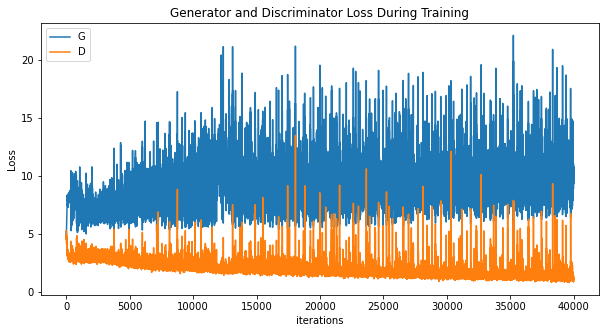

In [28]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:40000],label="G")
plt.plot(D_losses[:40000],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

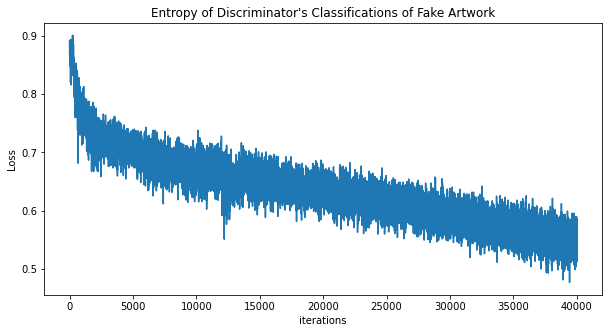

In [29]:
plt.figure(figsize=(10,5))
plt.title("Entropy of Discriminator's Classifications of Fake Artwork")
plt.plot(entropies[:40000])
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Visualize G's Progress
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Animation size has reached 21082618 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [19]:
len(img_list)

383

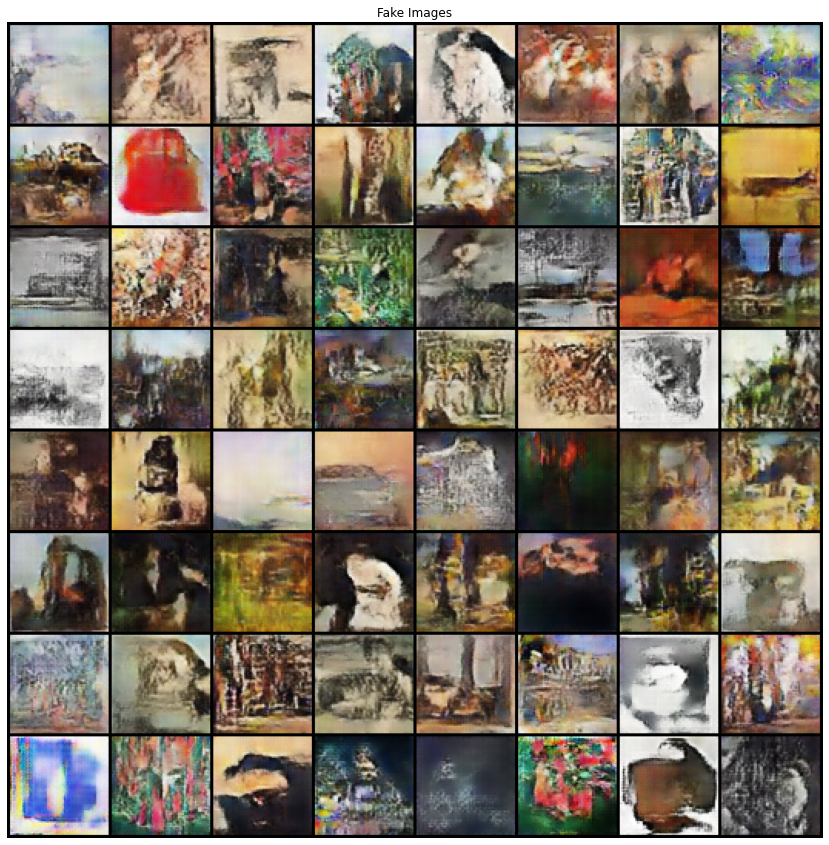

In [27]:
# Real vs Fake
# Grab a batch of real images from the dataloader
#real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
#plt.subplot(1,2,1)
#plt.axis("off")
#plt.title("Real Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
#plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[80],(1,2,0)))
plt.show()